# Fit linear readout predicting female walking from simulated neural activity in response to shuffled song

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import sys

import warnings
warnings.filterwarnings("ignore")

from aux import load_npy
from disp import set_plot
from record_0_main import smlt_ma
from my_torch import skl_fit_ridge

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS
NNRN = 224

NSHFL = 50
PTRAIN = .8

TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

PFX_BHV = f'data/simple/behav_xtd/behav_xtd'

NRL_MDL = 'ma'

ALPHA = 10

NSHFL_SAVE_Y_HAT = 5

MASK_PFX = 'data/simple/masks/mask'

if MASK_PFX:
    FSAVE_SFX = f'{TARG_BHV.lower()}_ridge_alpha_{ALPHA}_masked'
    PFX_NRL = f'data/simple/mlv/ma_shfl/temp_nrl/temp_ma_shfl_masked'
else:
    FSAVE_SFX = f'{TARG_BHV.lower()}_ridge_alpha_{ALPHA}'
    PFX_NRL = f'data/simple/mlv/ma_shfl/temp_nrl/temp_ma_shfl'

In [2]:
STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = len(ISTRAIN)
NTRAIN = int(round(PTRAIN*NTR))

Load behavioral data from Coen et al 2014

In [3]:
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')
df_behav

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077,-0.058526,0.274257
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044,0.100623,0.298490
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011,0.147629,0.271865
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016,0.091174,0.306112
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002,0.065871,0.306439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058,-0.171418,0.136184
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322,0.032522,0.249171
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260,0.033202,0.010844
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090,0.012059,0.027177


In [4]:
# split big df into dfs for individual trials
dfs_tr = [df_behav[df_behav.ID == i] for i in ISTRAIN]
tr_lens = np.array([len(df_tr) for df_tr in dfs_tr], dtype=int)

# trial start and stop idxs
istarts = cc([[0], tr_lens.cumsum()])[:-1]
istops = tr_lens.cumsum()

# concatenated song series (as binary currents)
i_s_cc = cc([np.array(df_tr['S']).astype(float) for df_tr in dfs_tr])
i_p_cc = cc([np.array(df_tr['P'] | df_tr['F']).astype(float) for df_tr in dfs_tr])

df_behav = None

In [5]:
# neural response fits from Baker data
ma_param = load_npy('data/simple/neur/baker_ma.npy')

r_cols = [f'R_{inrn}' for inrn in range(NNRN)]

In [6]:
import pdb

In [7]:
# run shuffled song recording/fitting analysis
save_data = {
    'r2_train': {targ: np.nan*np.zeros(NSHFL) for targ in TARGS},
    'r2_test': {targ: np.nan*np.zeros(NSHFL) for targ in TARGS},

    'w': {targ: [] for targ in TARGS},

    'ys_train': {targ: [] for targ in TARGS},
    'ys_test': {targ: [] for targ in TARGS},

    'y_hats_train': {targ: [] for targ in TARGS},
    'y_hats_test': {targ: [] for targ in TARGS},

    'targs': TARGS,
    'alpha': ALPHA,

    'ntr': NTR,
    'ntrain': NTRAIN,
    'nshfl': NSHFL,

    'nnrn': NNRN,
}

np.random.seed(0)

rolls = np.random.randint(0, len(i_s_cc), NSHFL)  # random amounts to timeshift concatenated song before resegmenting
seeds = np.arange(NSHFL)  # for seeding random training/test split

for cshfl, (roll, seed) in enumerate(zip(rolls, seeds)):
    sys.stdout.write(f'\nShuffle {cshfl}:\n')
    
    # shuffle song by rolling
    i_s_cc_shfl = np.roll(i_s_cc, roll)
    i_p_cc_shfl = np.roll(i_p_cc, roll)
    
    # split back into trials
    i_s_shfl = []
    i_p_shfl = []
    
    for istart, istop in zip(istarts, istops):
        i_s_shfl.append(i_s_cc_shfl[istart:istop])
        i_p_shfl.append(i_p_cc_shfl[istart:istop])
        
    # record neural activity to shuffled song
    sys.stdout.write('Recording')
    for itr, df_tr, i_s, i_p in zip(ISTRAIN, dfs_tr, i_s_shfl, i_p_shfl):
        sys.stdout.write('.')
        df_tr_nrl = df_tr.copy()
        
        rs = smlt_ma(i_s, i_p, ma_param, DT)
        
        df_tr_nrl[r_cols] = rs
        
        np.save(f'{PFX_NRL}_tr_{itr}.npy', np.array([{'df': df_tr_nrl}]))
    
    
    # fit neural -> MTN regression models
    sys.stdout.write('\nPredicting behavior...\n')

    try:
        rslts = skl_fit_ridge(
            pfxs=[PFX_NRL, PFX_BHV],
            cols_x=r_cols,
            targs=TARGS,
            itr_all=ISTRAIN, 
            ntrain=NTRAIN,
            nsplit=1,
            mask_pfx=MASK_PFX,
            return_y=np.array([0]),
            alpha=ALPHA,
            seed=seed,
            verbose=False)

        for targ in TARGS:
            # save r2, weights, and example predictions
            save_data['r2_train'][targ][cshfl] = rslts[0].r2_train[targ]
            save_data['r2_test'][targ][cshfl] = rslts[0].r2_test[targ]
            save_data['w'][targ].append(rslts[0].w[targ])

            if cshfl < NSHFL_SAVE_Y_HAT:
                save_data['ys_train'][targ].append(rslts[0].ys_train[targ])
                save_data['ys_test'][targ].append(rslts[0].ys_test[targ])

                save_data['y_hats_train'][targ].append(rslts[0].y_hats_train[targ])
                save_data['y_hats_test'][targ].append(rslts[0].y_hats_test[targ])
    except IndexError as e:
        print(e)
        
        for targ in TARGS:
            # save r2, weights, and example predictions
            save_data['r2_train'][targ][cshfl] = np.nan
            save_data['r2_test'][targ][cshfl] = np.nan
            save_data['w'][targ].append(np.repeat(np.nan, 224))

fsave = f'data/simple/mlv/ma_shfl/baker_{NRL_MDL}_{STRAIN_KEY}_{FSAVE_SFX}.npy'
np.save(fsave, np.array([save_data]))


Shuffle 0:
Recording.......................................................................................
Predicting behavior...

Shuffle 1:
Recording.......................................................................................
Predicting behavior...

Shuffle 2:
Recording.......................................................................................
Predicting behavior...

Shuffle 3:
Recording.......................................................................................
Predicting behavior...

Shuffle 4:
Recording.......................................................................................
Predicting behavior...

Shuffle 5:
Recording.......................................................................................
Predicting behavior...

Shuffle 6:
Recording.......................................................................................
Predicting behavior...

Shuffle 7:
Recording.......................................................

TARG: MTN_MN_0.03, r2 test: 0.03651351148517858
TARG: MTN_MN_1, r2 test: 0.05860500192138463
TARG: MTN_MN_60, r2 test: 0.026953521701489663


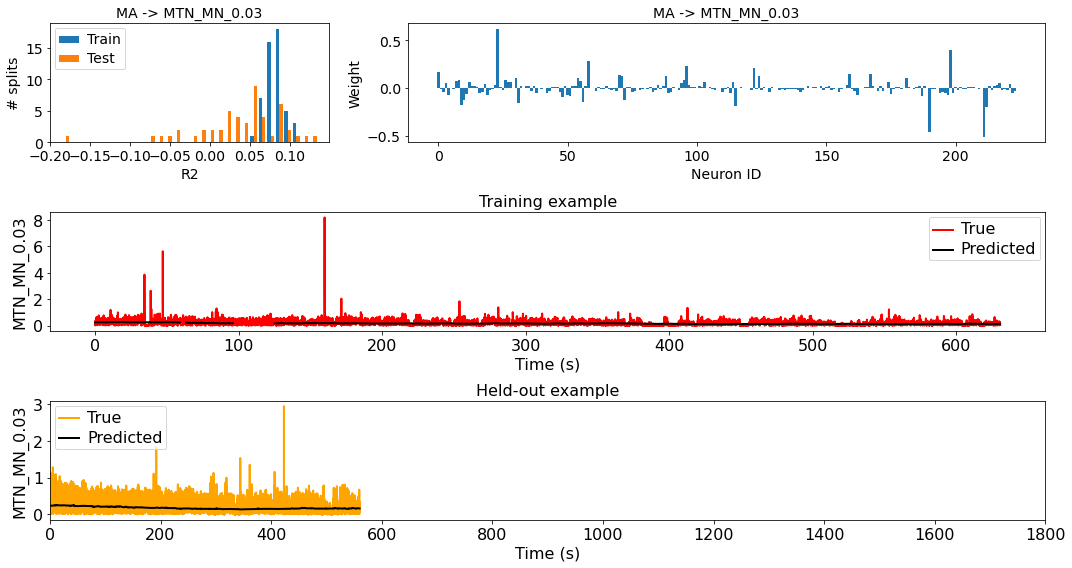

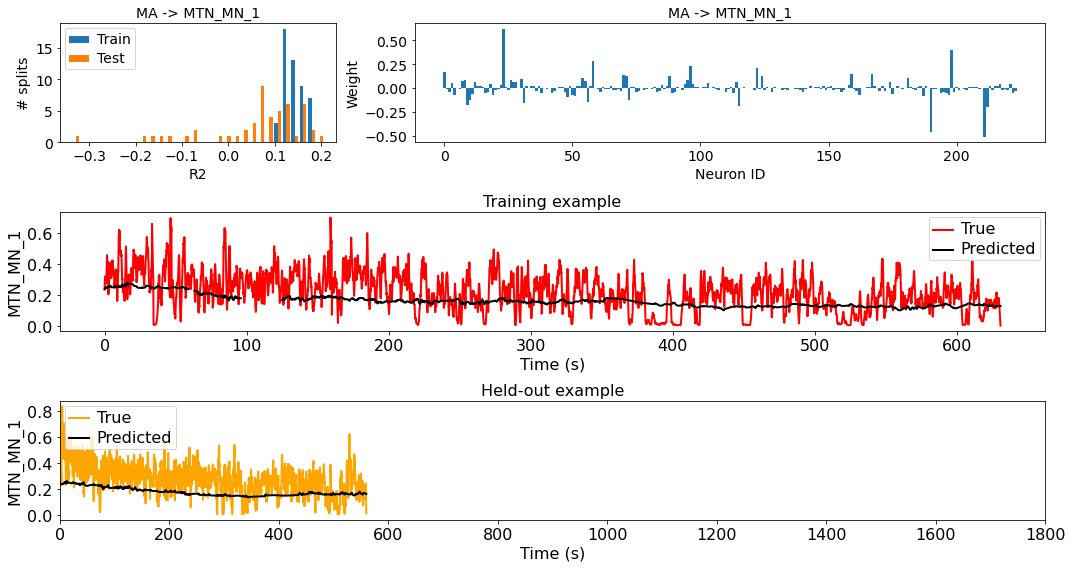

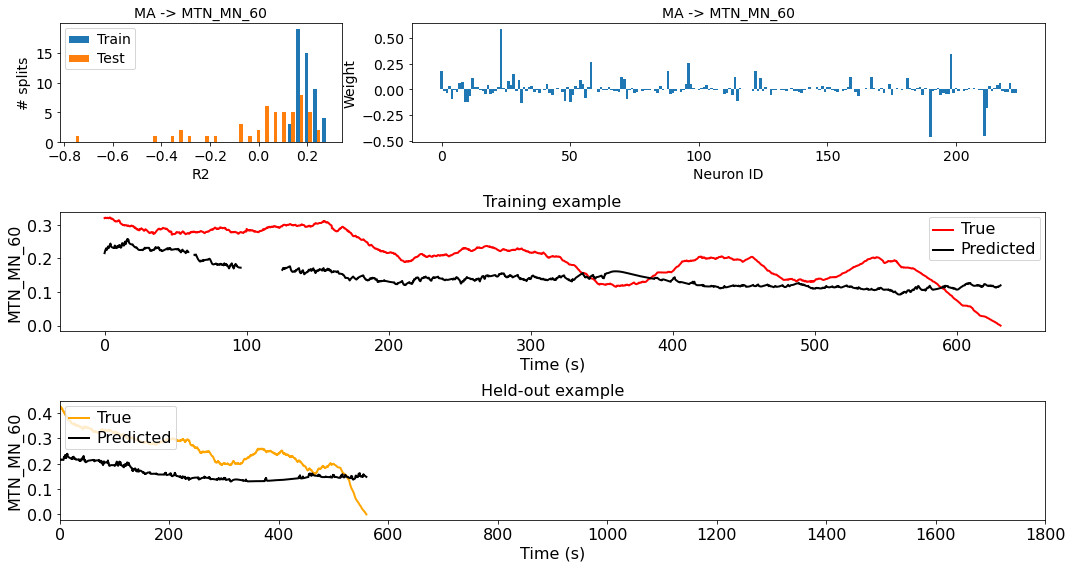

In [8]:
ISHFL = 0
ITRAIN_PLOT = 1
ITEST_PLOT = 1

FPS = 30.03

fsave = f'data/simple/mlv/ma_shfl/baker_{NRL_MDL}_{STRAIN_KEY}_{FSAVE_SFX}.npy'
data = np.load(fsave, allow_pickle=True)[0]

for targ in TARGS:

    r2_train = data['r2_train'][targ]
    r2_test = data['r2_test'][targ]
    
    print(f'TARG: {targ}, r2 test: {np.mean(r2_test)}')

    gs = gridspec.GridSpec(3, 3)

    fig = plt.figure(figsize=(15, 8), tight_layout=True)
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1:]), fig.add_subplot(gs[1, :]), fig.add_subplot(gs[2, :])]

    axs[0].hist(np.transpose([r2_train, r2_test]), bins=30)
    axs[0].legend(['Train', 'Test'])

    set_plot(axs[0], x_label='R2', y_label='# splits', title=f'{NRL_MDL.upper()} -> {targ}', font_size=14)

    axs[1].bar(np.arange(len(data['w'][targ][0])), np.mean(data['w'][targ], axis=0), width=1)
    set_plot(axs[1], x_label='Neuron ID', y_label='Weight', title=f'{NRL_MDL.upper()} -> {targ}', font_size=14)

    y_train = data['ys_train'][targ][ISHFL][ITRAIN_PLOT]
    t_train = np.arange(len(y_train))/FPS

    y_hat_train = data['y_hats_train'][targ][ISHFL][ITRAIN_PLOT]

    axs[2].plot(t_train, y_train, c='r', lw=2)
    axs[2].plot(t_train, y_hat_train, c='k', lw=2)

    axs[2].legend(['True', 'Predicted'])

    set_plot(axs[2], x_label='Time (s)', y_label=targ, title='Training example', font_size=16)

    y_test = data['ys_test'][targ][ISHFL][ITEST_PLOT]
    t_test = np.arange(len(y_test))/FPS

    y_hat_test = data['y_hats_test'][targ][ISHFL][ITEST_PLOT]

    axs[3].plot(t_test, y_test, c='orange', lw=2)
    axs[3].plot(t_test, y_hat_test, c='k', lw=2)

    axs[3].legend(['True', 'Predicted'], loc='upper left')

    set_plot(axs[3], x_lim=(0, 1800), x_label='Time (s)', y_label=targ, title='Held-out example', font_size=16)